In [112]:
import numpy as np
import matplotlib.pyplot as plt

In [113]:
params = {
    "save_timeseries_data": 1, 
    "total_steps": 15000,
    "compression_factor": 1,
    "I": 2000,
    "network_density": 0.1,
    "prob_rewire": 0.01,
    "set_seed": 11,
    "R": 1.0001,
    "a": 5.5,
    "d": 0.021,
    "theta_mean" : 0.0,
    "theta_sigma" :1,
    "epsilon_sigma": 4,
    "gamma_mean" : 0.0,
    "gamma_sigma" :1,
    "proportion_informed": 0.05,
    "proportion_misinformed": 0.05,
    "ar_1_coefficient": 0.9,
    "network_type": "scale_free",
    "w": 0.9,
    "misinformed_central": 1
}

Now we do have an analytic solution for the price so we use it. First we generate the stochastic vectors.

In [114]:
lamb = params["proportion_informed"]
xi = params["proportion_misinformed"]

theta = np.zeros(params["total_steps"])
gamma = np.zeros_like(theta)
theta[0] = params["theta_mean"]
gamma[0] = params["theta_mean"]
expected_uninfo_theta = np.zeros_like(theta)
expected_uninfo_theta[0] = params["theta_mean"]
for t in range(1,params["total_steps"]):
    theta[t] = params["ar_1_coefficient"] * theta[t-1] + params["theta_sigma"] * np.random.randn()
    gamma[t] = params["ar_1_coefficient"] * gamma[t-1] + params["gamma_sigma"] * np.random.randn()
    expected_uninfo_theta[t] = lamb * theta[t] + params["proportion_misinformed"] * gamma[t] + (1 - lamb - params["proportion_misinformed"]) * expected_uninfo_theta[t-1]

price_baseline = params["d"] / (params["R"] - 1) + \
    (lamb * theta * (params["R"] - params["ar_1_coefficient"])) / ((params["R"] - params["ar_1_coefficient"]) * params["epsilon_sigma"] ** 2 + params["theta_sigma"] ** 2) + \
    (xi * gamma * (params["R"] - params["ar_1_coefficient"])) / ((params["R"] - params["ar_1_coefficient"]) * params["epsilon_sigma"] ** 2 + params["gamma_sigma"] ** 2)


variance_info = params["epsilon_sigma"] ** 2 + params["theta_sigma"]**2 / (params["R"] - params["ar_1_coefficient"])**2
variance_misinfo = params["epsilon_sigma"] ** 2 + params["gamma_sigma"]**2 / (params["R"] - params["ar_1_coefficient"])**2
variance_uninfo = params["epsilon_sigma"] ** 2 + params["theta_sigma"]**2 / params["I"]


price_degroot = params["d"] / (params["R"] - 1) + \
    (lamb * theta * variance_misinfo * variance_uninfo + \
    xi * gamma * variance_info * variance_uninfo + \
    (1 - lamb - xi) * expected_uninfo_theta * variance_info * variance_misinfo) / \
    (lamb * variance_misinfo * variance_uninfo + xi * variance_info * variance_uninfo + (1 - lamb - xi) * variance_info * variance_misinfo) / \
    (params["R"] - params["ar_1_coefficient"])


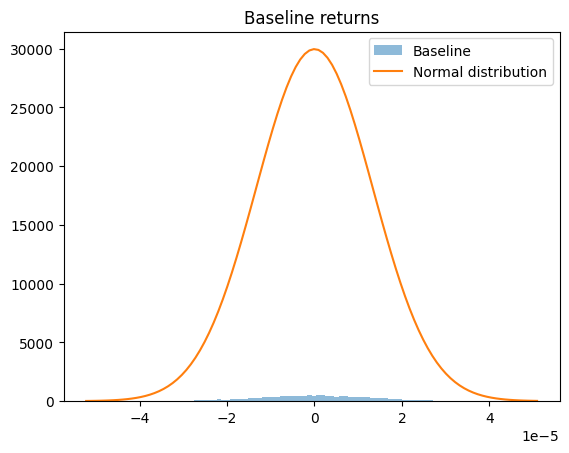

In [115]:
returns_baseline = price_baseline[1:] / price_baseline[:-1] - 1
returns_degroot = price_degroot[1:] / price_degroot[:-1] - 1

#plot the histogram of returns
plt.hist(returns_baseline, bins=100, alpha=0.5, label="Baseline")
#overlay normal distribution with same mean and variance
mu = np.mean(returns_baseline)
sigma = np.std(returns_baseline)
x = np.linspace(returns_baseline.min(), returns_baseline.max(),  100)
plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) ), label="Normal distribution")
plt.title("Baseline returns")
plt.legend()
plt.show()

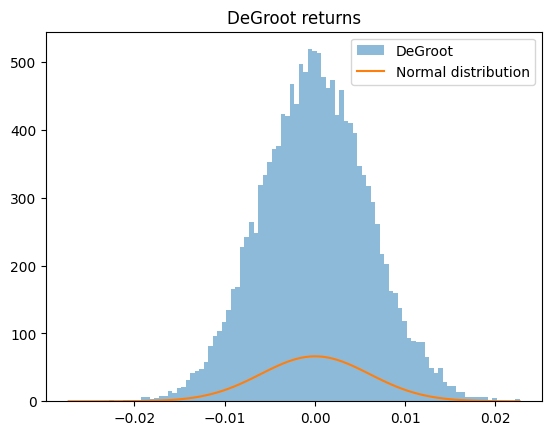

In [116]:
#histogram of returns for DeGroot
plt.hist(returns_degroot, bins=100, alpha=0.5, label="DeGroot")
#overlay normal distribution with same mean and variance
mu = np.mean(returns_degroot)
sigma = np.std(returns_degroot)
x = np.linspace(returns_degroot.min(), returns_degroot.max(),  100)
plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) ), label="Normal distribution")
plt.title("DeGroot returns")
plt.legend()
plt.show()

In [117]:
#compute skewness and kurtosis for both returns
skewness_baseline = np.mean((returns_baseline - np.mean(returns_baseline))**3) / np.std(returns_baseline)**3
kurtosis_baseline = np.mean((returns_baseline - np.mean(returns_baseline))**4) / np.std(returns_baseline)**4
skewness_degroot = np.mean((returns_degroot - np.mean(returns_degroot))**3) / np.std(returns_degroot)**3
kurtosis_degroot = np.mean((returns_degroot - np.mean(returns_degroot))**4) / np.std(returns_degroot)**4

print("Baseline skewness: ", skewness_baseline)
print("Baseline kurtosis: ", kurtosis_baseline)
print("DeGroot skewness: ", skewness_degroot)
print("DeGroot kurtosis: ", kurtosis_degroot)

Baseline skewness:  -0.03769634207933595
Baseline kurtosis:  2.919085640719899
DeGroot skewness:  0.027903911493670493
DeGroot kurtosis:  3.053429183887254


# Impulse response functions
Now we are going to compute impulse response to a shock of 1 std to theta. to properly identify the effect of the shock we shut down the noise until t = 10.

In [118]:
params["total_steps"] = 30
lamb = params["proportion_informed"]
xi = params["proportion_misinformed"]
shock_type = "misinfo"
theta = np.zeros(params["total_steps"])
gamma = np.zeros_like(theta)
theta[0] = params["theta_mean"]
gamma[0] = params["theta_mean"]
expected_uninfo_theta = np.zeros_like(theta)
expected_uninfo_theta[0] = params["theta_mean"]
for t in range(1,params["total_steps"]):
    if t == 10:
        if shock_type == "info":
            theta[t] = params["ar_1_coefficient"] * theta[t-1] + params["theta_sigma"] #* np.random.randn()
        else:
            gamma[t] = params["ar_1_coefficient"] * gamma[t-1] + params["gamma_sigma"] #* np.random.randn()
    else:
        theta[t] = params["ar_1_coefficient"] * theta[t-1]
        gamma[t] = params["ar_1_coefficient"] * gamma[t-1]
    expected_uninfo_theta[t] = params["proportion_informed"] * theta[t] + params["proportion_misinformed"] * gamma[t] + (1 - params["proportion_informed"] - params["proportion_misinformed"]) * expected_uninfo_theta[t-1]

price_baseline = params["d"] / (params["R"] - 1) + \
    (params["proportion_informed"] * theta * (params["R"] - params["ar_1_coefficient"])) / ((params["R"] - params["ar_1_coefficient"]) * params["epsilon_sigma"] ** 2 + params["theta_sigma"] ** 2) + \
    (params["proportion_misinformed"] * gamma * (params["R"] - params["ar_1_coefficient"])) / ((params["R"] - params["ar_1_coefficient"]) * params["epsilon_sigma"] ** 2 + params["gamma_sigma"] ** 2)

variance_info = params["epsilon_sigma"] ** 2 + params["theta_sigma"]**2 / (params["R"] - params["ar_1_coefficient"])**2
variance_misinfo = params["epsilon_sigma"] ** 2 + params["gamma_sigma"]**2 / (params["R"] - params["ar_1_coefficient"])**2
variance_uninfo = params["epsilon_sigma"] ** 2 + params["theta_sigma"]**2 / params["I"]




price_degroot = params["d"] / (params["R"] - 1) + \
    (lamb * theta * variance_misinfo * variance_uninfo + \
    xi * gamma * variance_info * variance_uninfo + \
    (1 - lamb - xi) * expected_uninfo_theta * variance_info * variance_misinfo) / \
    (lamb * variance_misinfo * variance_uninfo + xi * variance_info * variance_uninfo + (1 - lamb - xi) * variance_info * variance_misinfo) / \
    (params["R"] - params["ar_1_coefficient"])

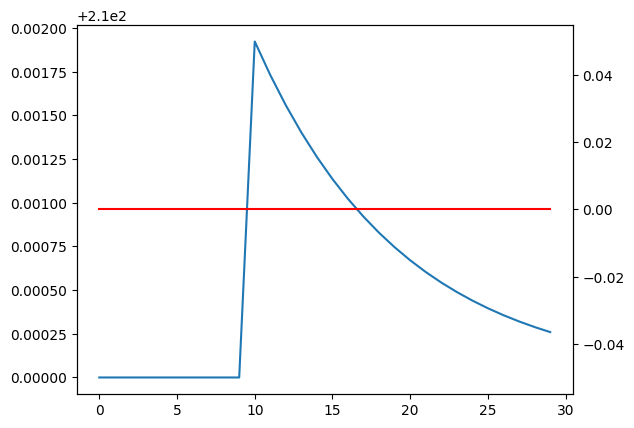

In [119]:
fig, ax = plt.subplots()
ax.plot(price_baseline, label="Baseline")

#twin axis for theta
ax2 = ax.twinx()
ax2.plot(theta, label="Theta", color="red")


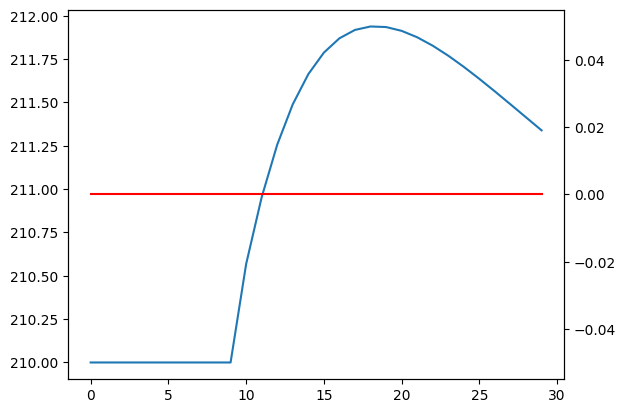

In [120]:
fig, ax = plt.subplots()
ax.plot(price_degroot, label="degroot")

#twin axis for theta
ax2 = ax.twinx()
ax2.plot(theta, label="Theta", color="red")